In [1]:
# Load the autoreload extension
%load_ext autoreload
# Enable autoreload for all modules (mode 2 is most comprehensive)
%autoreload 2

In [2]:
from temperament_functions import *
import temperament_functions # to facilitate importlib.reload(temperament_functions) for debugging.
import os
import json
from copy import deepcopy
import numpy as np


In [ ]:
INTERVAL_TYPES_ALL = {
    0: {"name": "P1", "targets": [0.0]},
    3: {"name": "m3", "targets": [315.64, 297.51, 294.13]},
    4: {"name": "M3", "targets": [386.31, 407.82]},
    5: {"name": "P4", "targets": [498.04]},
    7: {"name": "P5", "targets": [701.96]},
    8: {"name": "m6", "targets": [813.69, 792.18, 782.49]},
    9: {"name": "M6", "targets": [884.36, 905.87]},
    12: {"name": "P8", "targets": [1200.0]},

    1: {"name": "m2", "targets": [111.73, 104.96, 133.24, 92.18, 90.22, 70.67]},
    2: {"name": "M2", "targets": [203.91, 182.4]},
    6: {"name": "A4/d5", "targets": [590.22, 582.51, 617.49, 636.62, 563.38, 568.72, 631.28, 609.78]},
    10: {"name": "m7", "targets": [996.09, 1017.6]},
    11: {"name": "M7", "targets": [1088.27, 1066.76, 1109.78]}, #pyth major seventh added
}

RATIOS_REFERENCE_ALL = {
    0: ["1/1"],
    1: ["16/15", "17/16", "27/25", "135/128", "256/243", "25/24"],
    2: ["9/8", "10/9"],
    3: ["6/5", "19/16", "32/27"],
    4: ["5/4", "81/64"],
    5: ["4/3"],
    6: ["45/32", "7/5", "10/7", "13/9", "18/13", "25/18", "36/25", "64/45"],
    7: ["3/2"],
    8: ["8/5", "128/81", "11/7"],
    9: ["5/3", "27/16"],
    10: ["16/9", "9/5"],
    11: ["15/8", "50/27", "243/128"], #pyth major seventh added
    12: ["2/1"]
}

INTERVAL_TYPES_FIVE_LIMIT = {
    0: {"name": "P1", "targets": [0.0]},
    3: {"name": "m3", "targets": [315.64]},
    4: {"name": "M3", "targets": [386.31]},
    5: {"name": "P4", "targets": [498.04]},
    7: {"name": "P5", "targets": [701.96]},
    8: {"name": "m6", "targets": [813.69]},
    9: {"name": "M6", "targets": [884.36]},

    1: {"name": "m2", "targets": [111.73]},
    2: {"name": "M2", "targets": [203.91]},
    6: {"name": "A4/d5", "targets": [590.22]},
    10: {"name": "m7", "targets": [996.09]},
    11: {"name": "M7", "targets": [1088.27]},
}

In [4]:
import numpy as np

# Krumhansl-Kessler weights for C major and C minor
c_major_weights = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
c_minor_weights = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.98, 2.67, 5.61, 4.56, 2.69, 3.58, 2.54])

#Only scale tones and base weights:
res=0.0
c_major_weights = np.array([6.35, res, 3.48, res, 4.38, 4.09, res, 5.19, res, 3.66, res, 2.88])
c_minor_weights = np.array([6.33, res, 3.52, 5.38, res, 3.98, res, 5.61, 4.56, 2.69, 3.58, 2.54])

# Pitch class names for reference
pitch_classes = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

# Normalize weights to probabilities
def normalize_weights(weights):
    total = sum(weights)
    return [w / total for w in weights]

c_major_probs = normalize_weights(c_major_weights)
c_minor_probs = normalize_weights(c_minor_weights)

# Function to sample a pair of notes
def sample_note_pair(probabilities, num_pairs=1):
    # Sample pairs using the probabilities
    pairs = np.random.choice(len(probabilities), size=(num_pairs, 2), p=probabilities)
    return pairs

def sample_note_pair_related_keys(major_probs, minor_probs, num_pairs=1):
    # Sample pairs using the probabilities
    num_pairs_tonic  = int(num_pairs * 0.4)
    num_pairs_dom    = int(num_pairs * 0.3)
    num_pairs_subdom = int(num_pairs * 0.2)
    num_pairs_par    = int(num_pairs * 0.2)
    pairs_tonic  = np.random.choice(len(major_probs), size=(num_pairs_tonic, 2), p=major_probs)
    pairs_dom    = np.random.choice(len(major_probs), size=(num_pairs_dom, 2), p=np.roll(major_probs, 7))
    pairs_subdom = np.random.choice(len(major_probs), size=(num_pairs_subdom, 2), p=np.roll(major_probs, 5))
    pairs_par    = np.random.choice(len(minor_probs), size=(num_pairs_par, 2), p=np.roll(minor_probs, 9))
    return np.concatenate([pairs_tonic, pairs_dom, pairs_subdom, pairs_par], axis=0)

def pairs2frequencies(pairs):
    # Heuristic weights based on tonal harmony (higher for P5, P4, M3, lower for m2, tritone)
    interval_weights = {
        0: 10.0,  # P1 (unison or octave)
        1: 1.0,   # m2 (rare in harmony)
        2: 3.0,   # M2 (common in melody)
        3: 4.0,   # m3 (subdominant harmony)
        4: 6.0,   # M3 (tonic/dominant harmony)
        5: 8.0,   # P4 (subdominant)
        6: 2.0,   # A4/d5 (tritone, dissonant)
        7: 10.0,  # P5 (strongest harmonic interval)
        8: 3.0,   # m6 (less common)
        9: 5.0,   # M6 (tonic harmony)
        10: 2.0,  # m7 (dominant seventh)
        11: 4.0,  # M7 (leading tone to octave)
    }
    pair_frequencies = defaultdict(float)
    for note1, note2 in pairs:
        interval = int((note2-note1) % 12)
        pair_frequencies[(int(note1), int(note2), interval)] += interval_weights[interval]
        #pair_frequencies[(int(note1), int(note2), interval)] += 1
    return pair_frequencies

major_pairs = sample_note_pair(c_major_probs, num_pairs=144*1000)
major_related_pairs = sample_note_pair_related_keys(c_major_probs, c_minor_probs, num_pairs=144000)


In [5]:
major_frequencies = pairs2frequencies(major_pairs)
major_interval_data = compute_interval_data(major_frequencies, INTERVAL_TYPES_ALL, total_weight=1)
major_related_frequencies = pairs2frequencies(major_related_pairs)
major_related_interval_data_all_ratios = compute_interval_data(major_related_frequencies, INTERVAL_TYPES_ALL, total_weight=1)
major_related_interval_data_five_limit = compute_interval_data(major_related_frequencies, INTERVAL_TYPES_FIVE_LIMIT, total_weight=1)

In [6]:
pprint_interval_data(major_related_interval_data_all_ratios)

Sorted by interval
--- P1 ---
C  - C  : 0.0514
G  - G  : 0.0471
A  - A  : 0.0313
F  - F  : 0.0298
E  - E  : 0.0288
D  - D  : 0.0286
B  - B  : 0.0187
F# - F# : 0.0066
Bb - Bb : 0.0059
Ab - Ab : 0.0015
--- m2 ---
B  - C  : 0.0025
E  - F  : 0.0024
F# - G  : 0.0012
A  - Bb : 0.0006
Ab - A  : 0.0003
F  - F# : 0.0003
G  - Ab : 0.0002
--- M2 ---
C  - D  : 0.0115
G  - A  : 0.0109
D  - E  : 0.0088
F  - G  : 0.0077
A  - B  : 0.0062
E  - F# : 0.0028
Bb - C  : 0.0022
F# - Ab : 0.0004
--- m3 ---
A  - C  : 0.0159
E  - G  : 0.0145
D  - F  : 0.0087
B  - D  : 0.0084
F# - A  : 0.0036
G  - Bb : 0.0020
F  - Ab : 0.0009
Ab - B  : 0.0008
--- M3 ---
C  - E  : 0.0233
G  - B  : 0.0164
F  - A  : 0.0160
D  - F# : 0.0061
Bb - D  : 0.0029
Ab - C  : 0.0017
E  - Ab : 0.0016
--- P4 ---
G  - C  : 0.0383
D  - G  : 0.0297
C  - F  : 0.0283
E  - A  : 0.0239
A  - D  : 0.0230
B  - E  : 0.0170
F  - Bb : 0.0076
F# - B  : 0.0070
--- A4-d5 ---
B  - F  : 0.0024
F  - B  : 0.0022
C  - F# : 0.0018
F# - C  : 0.0018
E  - Bb : 0.0009


In [ ]:
res = {}
results = compute_temperaments_ismir2025(
    {
        'major_related_interval_data_all_ratios': major_related_interval_data_all_ratios,
        'major_related_interval_data_five_limit': major_related_interval_data_five_limit
    },
    {
        "Unbounded Fifths": None,
        # "Fifths in (696-705)": (696, 705)
    },
    ['dual_annealing', 'basinhopping','differential_evolution'],
    overwriteResults=False,
    no_runs = 10,
    result=res,
    inherit_p = False,
    verbose = True,
    store_all_runs=True
)

Configuration:  major_related_interval_data_all_ratios_Unbounded Fifths_dual_annealing
  da_i_t=10.0
  Run 0
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   ,  92.265, 203.92 , 275.685, 407.84 , 498.04 , 611.76 , 701.96 , 794.15 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.22734831314948
    runtime=370.977706 seconds.
    Selected.
  Run 1
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   ,  84.839, 203.92 , 311.604, 407.84 , 498.04 , 611.76 , 701.96 , 794.15 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.227392281888621
    runtime=384.498018 seconds.
    Selected.
  Run 2
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   , 103.878, 203.92 , 282.7  , 407.84 , 498.04 , 611.76 , 701.96 , 794.15 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.227392285347657
    runtime=338.38723099999993 seconds.
    Selected.
  Run 3
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800

/Users/Krane108/.pyenv/versions/3.12.2/envs/ismir2025/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/Krane108/.pyenv/versions/3.12.2/envs/ismir2025/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


    tuning=[   0.   ,  82.76 , 203.92 , 281.738, 407.84 , 498.04 , 611.76 , 701.96 , 813.69 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.224600931208407
    runtime=61.569751999999426 seconds.
    Selected.
  Run 1
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   ,  84.221, 203.92 , 281.661, 407.84 , 498.04 , 611.76 , 701.96 , 813.69 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.224601012805088
    runtime=58.197384999999485 seconds.
    Selected.
  Run 2
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   ,  99.501, 203.92 , 289.694, 407.84 , 498.04 , 611.76 , 701.96 , 813.69 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.224601008357952
    runtime=56.53686000000016 seconds.
  Run 3
    p0=[ 100, 200, 300, 400, 500, 600, 700, 800, 900,1000,1100]
    tuning=[   0.   ,  91.435, 203.92 , 276.33 , 407.84 , 498.04 , 611.76 , 701.96 , 794.15 , 905.88 , 996.08 ,1109.8  ,1200.   ]
    obj_val=-7.227392238

In [ ]:
with open('results/results_major_related.json', 'w') as f:
   json.dump(results, f, indent=2)

In [9]:
for key, res in results.items():
    print(key)
    print(f" Best result: {round(res['best_result']['obj_val'],4)}")
    runtimes = [run['runtime'] for run in res["all_runs"]]
    losses = [run['obj_val'] for run in res["all_runs"]]
    print(f" Std.dev Loss: {np.std(losses)}") 
    print(f" Avg runtime: {np.average(runtimes)}")
    print(f" Std.dev runtime: {np.std(runtimes)}")

major_related_interval_data_all_ratios_Unbounded Fifths_dual_annealing
 Best result: -7.2274
 Std.dev Loss: 0.00022111852763423637
 Avg runtime: 360.49230069999993
 Std.dev runtime: 26.179334370284728
major_related_interval_data_all_ratios_Unbounded Fifths_basinhopping
 Best result: -7.212
 Std.dev Loss: 0.023512684438520177
 Avg runtime: 317.38635320000014
 Std.dev runtime: 10.901656055394135
major_related_interval_data_all_ratios_Unbounded Fifths_differential_evolution
 Best result: -7.2274
 Std.dev Loss: 0.001367423867467989
 Avg runtime: 59.94950569999992
 Std.dev runtime: 1.8545050097558216
major_related_interval_data_five_limit_Unbounded Fifths_dual_annealing
 Best result: 27.7735
 Std.dev Loss: 4.063789554647571e-06
 Avg runtime: 204.6813449000004
 Std.dev runtime: 20.91071659663071
major_related_interval_data_five_limit_Unbounded Fifths_basinhopping
 Best result: 27.7823
 Std.dev Loss: 0.002885484365489189
 Avg runtime: 528.0278214
 Std.dev runtime: 38.37477261526284
major_rela

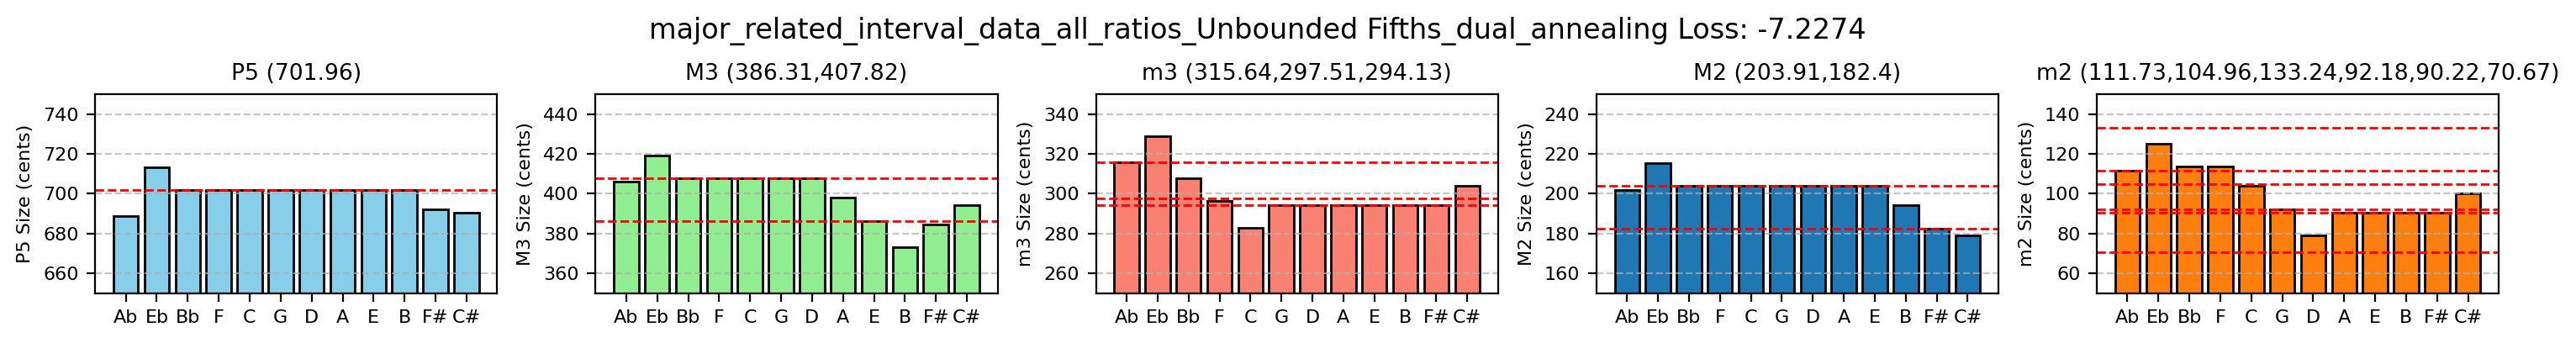

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00  103.88  203.92  282.70  407.84  498.04  611.76  701.96  794.15  905.88  996.08 1109.80
C#     0.00  100.04  178.82  303.96  394.16  507.88  598.08  690.27  802.00  892.20 1005.92 1096.12
D      0.00   78.78  203.92  294.12  407.84  498.04  590.23  701.96  792.16  905.88  996.08 1099.96
Eb     0.00  125.14  215.34  329.06  419.26  511.45  623.18  713.38  827.10  917.30 1021.18 1121.22
E      0.00   90.20  203.92  294.12  386.31  498.04  588.24  701.96  792.16  896.04  996.08 1074.86
F      0.00  113.72  203.92  296.11  407.84  498.04  611.76  701.96  805.84  905.88  984.66 1109.80
F#     0.00   90.20  182.39  294.12  384.32  498.04  588.24  692.12  792.16  870.94  996.08 1086.28
G      0.00   92.19  203.92  294.12  407.84  498.04  601.92  701.96  780.74  905.88  996.08 1109.80
Ab     0.00  111.73  201.93  315.65  405.85  509.73  609.77  688.55  813.69  903.89 1017.61 1107.81


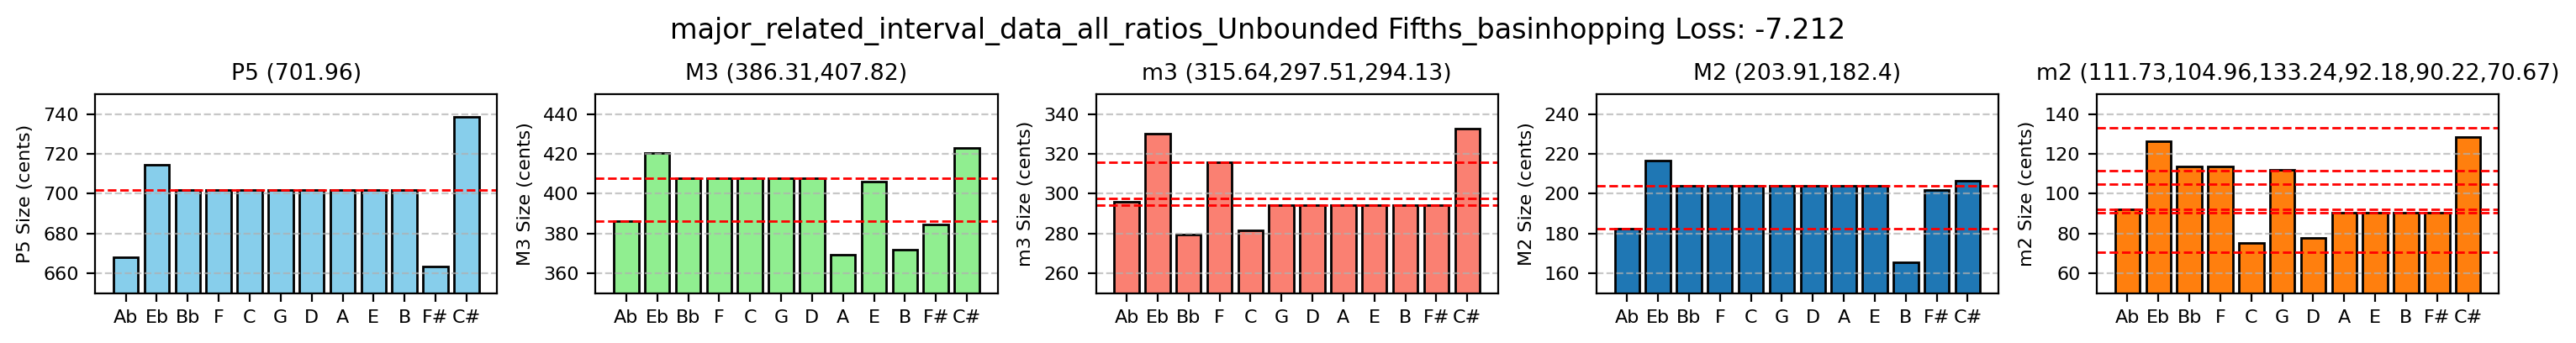

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00   75.30  203.92  281.61  407.84  498.04  611.76  701.96  813.73  905.88  996.06 1109.80
C#     0.00  128.62  206.31  332.54  422.74  536.46  626.66  738.44  830.58  920.77 1034.50 1124.70
D      0.00   77.69  203.92  294.12  407.84  498.04  609.81  701.96  792.14  905.88  996.08 1071.38
Eb     0.00  126.23  216.43  330.15  420.35  532.12  624.27  714.45  828.19  918.39  993.69 1122.31
E      0.00   90.20  203.92  294.12  405.89  498.04  588.22  701.96  792.16  867.46  996.08 1073.77
F      0.00  113.72  203.92  315.69  407.84  498.02  611.76  701.96  777.26  905.88  983.57 1109.80
F#     0.00   90.20  201.97  294.12  384.31  498.04  588.24  663.54  792.16  869.85  996.08 1086.28
G      0.00  111.77  203.92  294.10  407.84  498.04  573.34  701.96  779.65  905.88  996.08 1109.80
Ab     0.00   92.15  182.33  296.07  386.27  461.56  590.19  667.88  794.11  884.31  998.03 1088.23


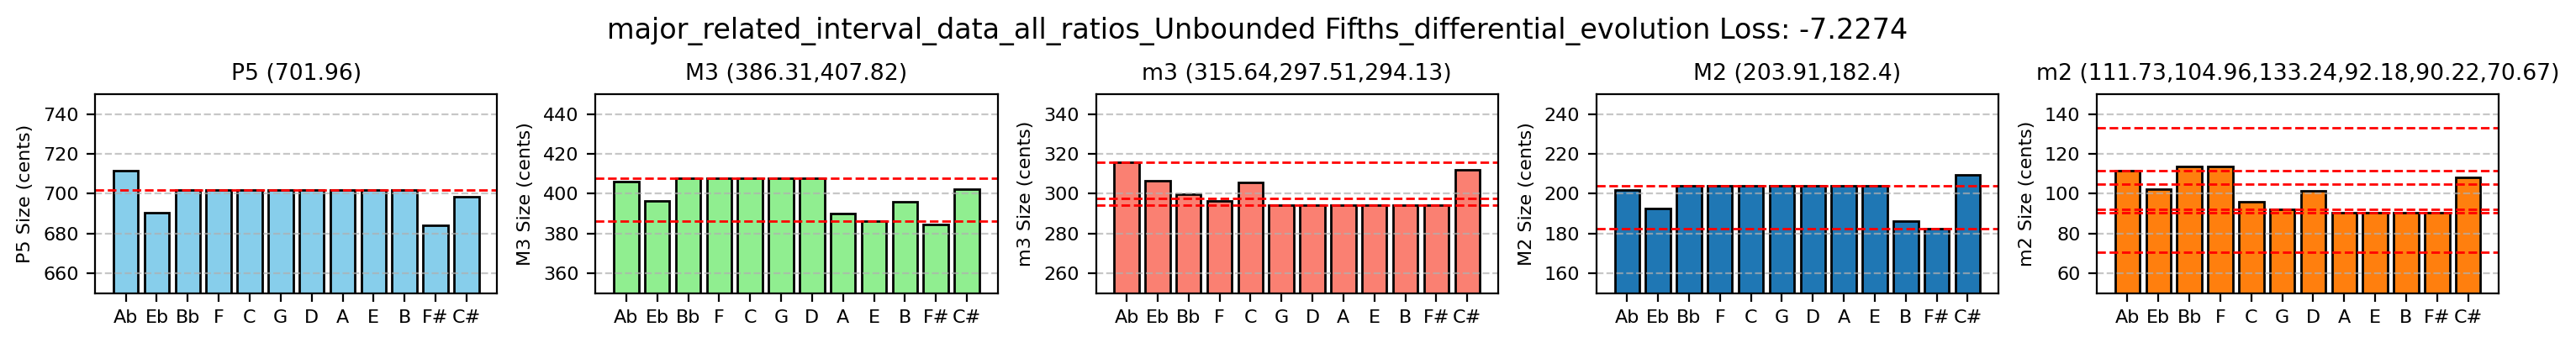

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00   95.87  203.92  305.49  407.84  498.04  611.76  701.96  794.15  905.88  996.08 1109.80
C#     0.00  108.05  209.62  311.97  402.17  515.89  606.09  698.28  810.01  900.21 1013.93 1104.13
D      0.00  101.57  203.92  294.12  407.84  498.04  590.23  701.96  792.16  905.88  996.08 1091.95
Eb     0.00  102.35  192.55  306.27  396.47  488.66  600.39  690.59  804.31  894.51  990.38 1098.43
E      0.00   90.20  203.92  294.12  386.31  498.04  588.24  701.96  792.16  888.03  996.08 1097.65
F      0.00  113.72  203.92  296.11  407.84  498.04  611.76  701.96  797.83  905.88 1007.45 1109.80
F#     0.00   90.20  182.39  294.12  384.32  498.04  588.24  684.11  792.16  893.73  996.08 1086.28
G      0.00   92.19  203.92  294.12  407.84  498.04  593.91  701.96  803.53  905.88  996.08 1109.80
Ab     0.00  111.73  201.93  315.65  405.85  501.72  609.77  711.34  813.69  903.89 1017.61 1107.81


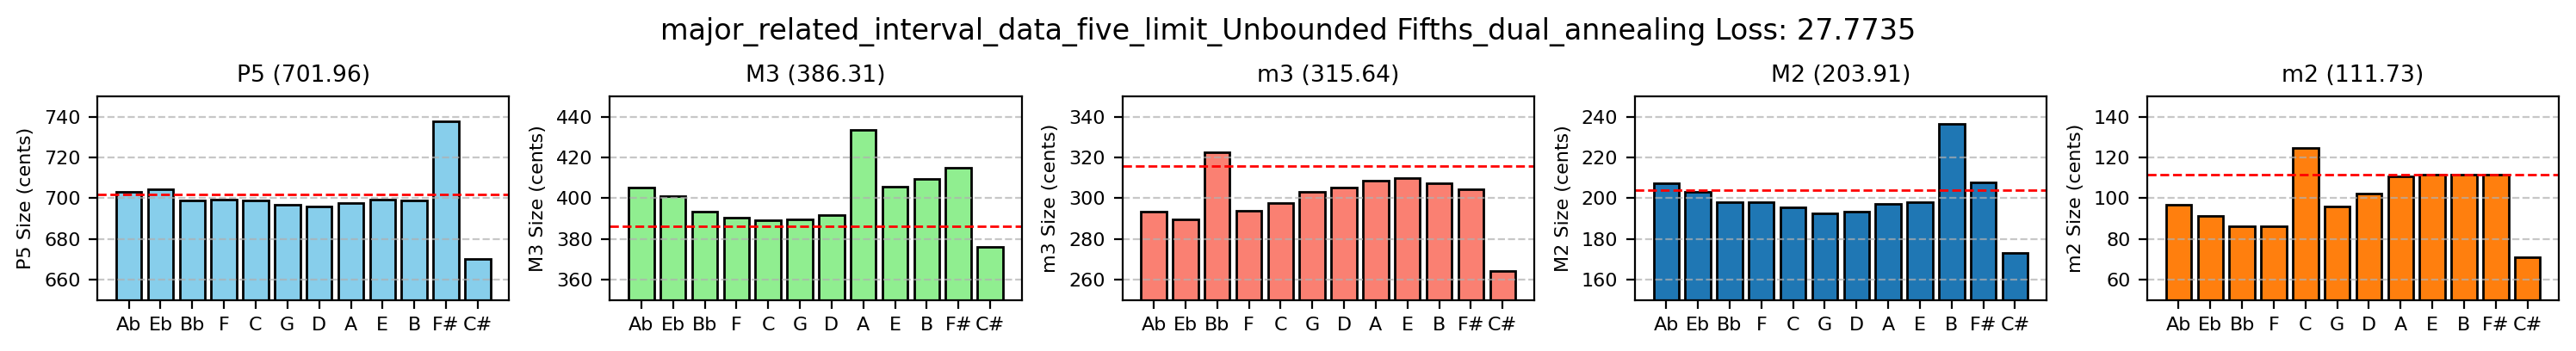

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00  124.73  195.58  297.73  389.03  500.76  587.11  698.84  794.71  891.27 1002.04 1088.27
C#     0.00   70.85  173.00  264.30  376.03  462.38  574.11  669.98  766.55  877.31  963.54 1075.27
D      0.00  102.14  193.45  305.18  391.53  503.26  599.12  695.69  806.45  892.69 1004.42 1129.15
Eb     0.00   91.30  203.03  289.38  401.11  496.98  593.55  704.31  790.54  902.27 1027.00 1097.86
E      0.00  111.73  198.08  309.81  405.68  502.24  613.01  699.24  810.97  935.70 1006.55 1108.70
F      0.00   86.35  198.08  293.95  390.51  501.28  587.51  699.24  823.97  894.82  996.97 1088.27
F#     0.00  111.73  207.60  304.17  414.93  501.16  612.89  737.62  808.47  910.62 1001.92 1113.65
G      0.00   95.87  192.44  303.20  389.43  501.16  625.89  696.74  798.89  890.19 1001.92 1088.27
Ab     0.00   96.57  207.33  293.56  405.29  530.02  600.88  703.02  794.32  906.05  992.40 1104.13


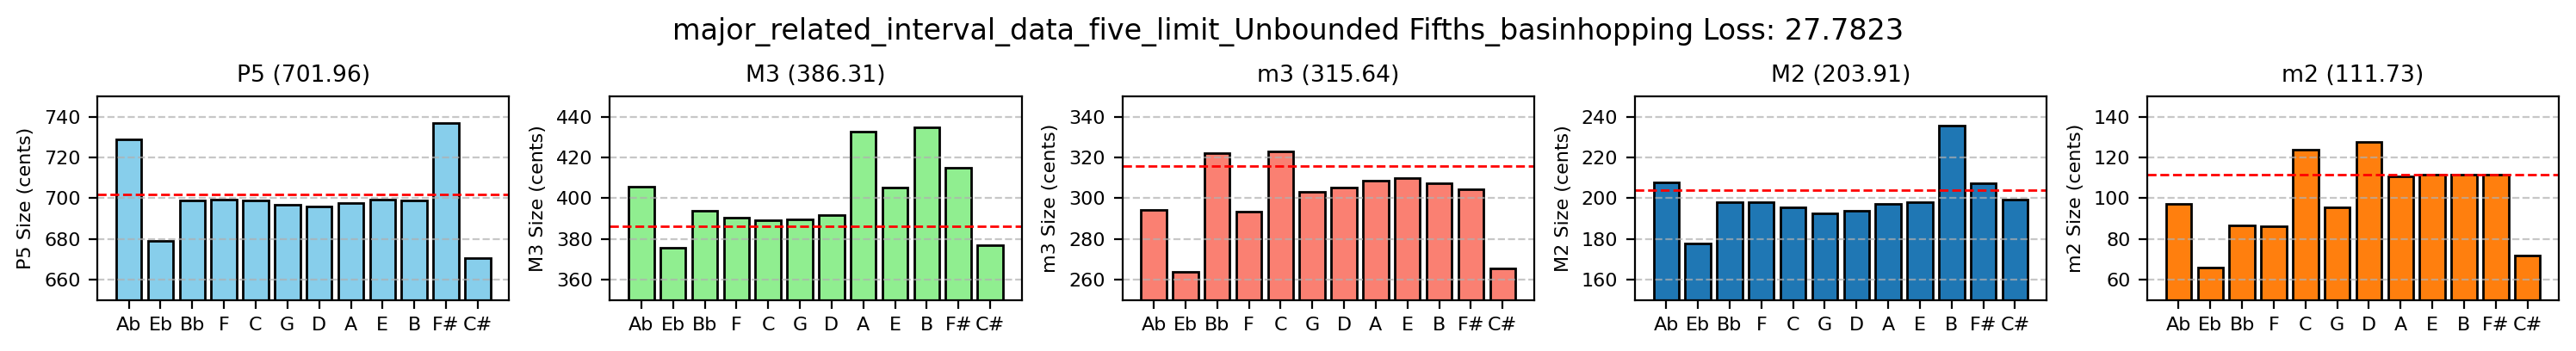

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00  123.80  195.48  323.06  389.04  500.77  587.00  698.72  794.19  891.28 1001.88 1088.27
C#     0.00   71.68  199.26  265.24  376.97  463.20  574.92  670.39  767.48  878.08  964.47 1076.20
D      0.00  127.58  193.57  305.30  391.52  503.25  598.71  695.80  806.40  892.79 1004.52 1128.32
Eb     0.00   65.99  177.72  263.94  375.67  471.13  568.22  678.82  765.21  876.94 1000.74 1072.42
E      0.00  111.73  197.96  309.68  405.15  502.24  612.83  699.23  810.96  934.76 1006.43 1134.01
F      0.00   86.23  197.95  293.42  390.51  501.10  587.50  699.23  823.03  894.70 1022.28 1088.27
F#     0.00  111.72  207.19  304.28  414.88  501.27  613.00  736.80  808.48  936.06 1002.04 1113.77
G      0.00   95.47  192.56  303.15  389.55  501.28  625.08  696.75  824.33  890.32 1002.05 1088.28
Ab     0.00   97.09  207.69  294.08  405.81  529.61  601.29  728.87  794.85  906.58  992.81 1104.53


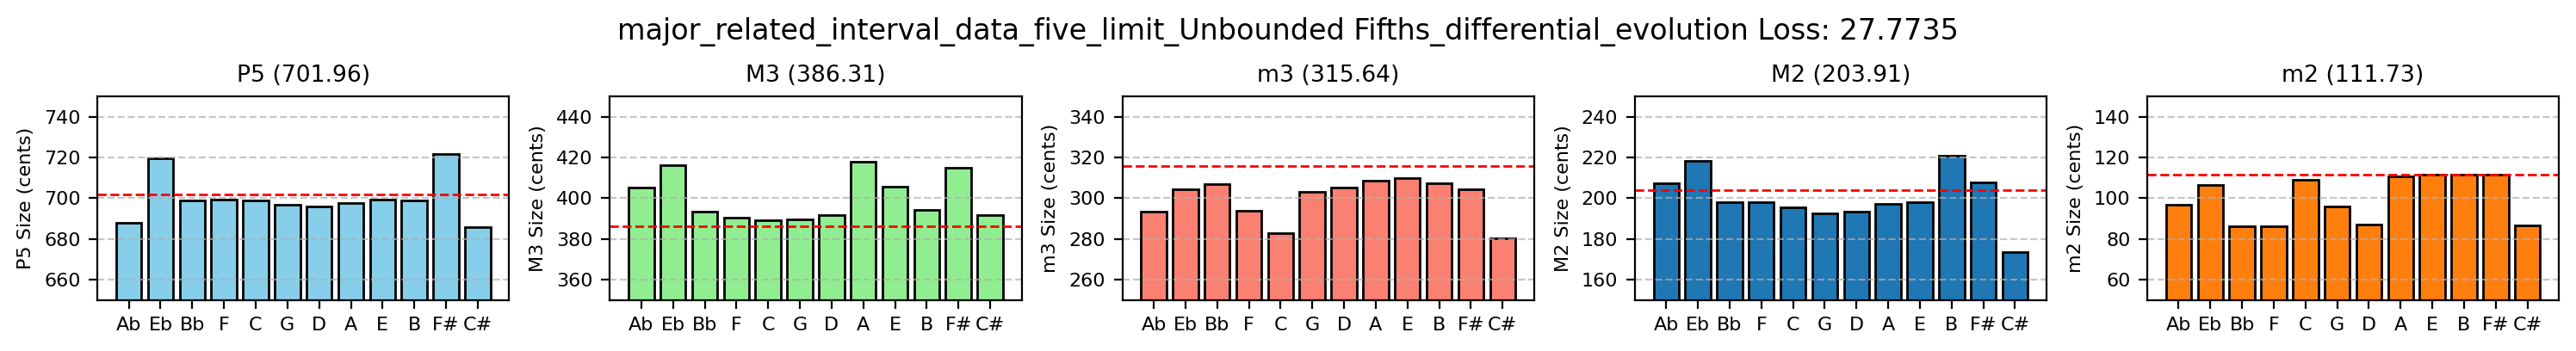

        P1      m2      M2      m3      M3      P4   A4-d5      P5      m6      M6      m7      M7 
C      0.00  108.97  195.58  282.58  389.03  500.76  587.11  698.84  794.71  891.27 1002.04 1088.27
C#     0.00   86.61  173.61  280.06  391.79  478.14  589.87  685.74  782.30  893.07  979.30 1091.03
D      0.00   87.00  193.45  305.18  391.53  503.26  599.12  695.69  806.45  892.69 1004.42 1113.39
Eb     0.00  106.45  218.18  304.53  416.26  512.13  608.69  719.46  805.69  917.42 1026.39 1113.00
E      0.00  111.73  198.08  309.81  405.68  502.24  613.01  699.24  810.97  919.94 1006.55 1093.55
F      0.00   86.35  198.08  293.95  390.51  501.28  587.51  699.24  808.21  894.82  981.82 1088.27
F#     0.00  111.73  207.60  304.17  414.93  501.16  612.89  721.86  808.47  895.47 1001.92 1113.65
G      0.00   95.87  192.44  303.20  389.43  501.16  610.13  696.74  783.74  890.19 1001.92 1088.27
Ab     0.00   96.57  207.33  293.56  405.29  514.26  600.88  687.87  794.32  906.05  992.40 1104.13


In [10]:
for key, res in results.items():
    tuning = res['best_result']['tuning']
    if 'all_ratios' in key:
        interval_types = INTERVAL_TYPES_ALL
    elif 'five_limit' in key:
        interval_types = INTERVAL_TYPES_FIVE_LIMIT
    else:
        interval_types = None
    plotBie(
        tuning,
        key + f" Loss: {round(res['best_result']['obj_val'],4)}",
        intervals=[7,4,3,2,1],
        interval_types=interval_types,
        saveplot=True,
        filename=key + '.pdf',
        orientation='horizontal'
    )
    printIntervalSizes(
        computeIntervalSizes(
            tuning
        )
    )


In [ ]:
SCALA_CENT_PATH = './scl_cents'
scala_cent_fnmames = sorted([os.path.join(SCALA_CENT_PATH, f) for f in os.listdir(SCALA_CENT_PATH) if f.endswith('.txt')])
historic_tunings = {}
for fn in scala_cent_fnmames:
    tuning_name = os.path.splitext(os.path.basename(fn))[0]
    with open(fn, 'r') as f:
        cents_list = f.readline().strip()
        historic_tunings[tuning_name] = [0.0] + json.loads(cents_list) + [1200.0]

In [12]:
results_hist = {}
for tuning_name in historic_tunings.keys():
    compute_obj_val_ismir2025(
        {
            'major_related_interval_data_all_ratios': major_related_interval_data_all_ratios,
            'major_related_interval_data_five_limit': major_related_interval_data_five_limit
        },
        {
            "Unbounded Fifths": None,
            "Fifths in (696-705)": (696, 705)
        },
        p_in=historic_tunings[tuning_name],
        p_name=tuning_name,
        results=results_hist,
        verbose = True,
        verbose_procedure=False,
        verbose_optimizer=False,
        verbose_objective=False,
    )

In [13]:
historic_sorted = {}
for conf in [
    'all_ratios_Unbounded Fifths',
    'all_ratios_Fifths in (696-705)',
    'five_limit_Unbounded Fifths',
    'five_limit_Fifths in (696-705)',
]:
    historic_sorted[conf] = sorted([t for key, t in results_hist.items() if t['obj_val'] != np.inf and conf in key], key=lambda x: x['obj_val'])

In [14]:
for conf in [
    'all_ratios_Unbounded Fifths',
    'all_ratios_Fifths in (696-705)',
    'five_limit_Unbounded Fifths',
    'five_limit_Fifths in (696-705)',
]:
    print(f"--------- {conf} ---------")
    for t in historic_sorted[conf][:20]:
        print(f"{t['name']}\t{round(t['obj_val'],4)}")
    print()


--------- all_ratios_Unbounded Fifths ---------
pyth_12	-7.1467
parizek_jiwt2	-5.8116
raintree	-5.3601
duoden12	-5.0083
mistyschism	-5.0017
bemetzrieder2	-4.538
marpurg-t11	-4.538
cotoneum12	-3.8237
coul_12sup	-3.5981
valentine	-2.5929
wiese1	-1.8448
organ1373a	-1.4398
marpurg-t12	-1.2974
wiese3	-0.8206
agricola	-0.0669
agricola_p	0.3428
organ1373b	1.1956
pipedum_12l	1.5115
pyth_7a	1.5955
zwolle	1.7283

--------- all_ratios_Fifths in (696-705) ---------
pyth_12	-7.1467
parizek_jiwt2	-5.8116
raintree	-5.3601
duoden12	-5.0083
mistyschism	-5.0017
bemetzrieder2	-4.538
marpurg-t11	-4.538
cotoneum12	-3.8237
valentine	-2.5929
marpurg-t12	-1.2974
hahn_g	1.8475
marpurg-t9	2.9311
ponsford2	5.7248
morgan	5.8692
bermudo-v	6.2669
temp12b2w	6.6097
temp12ebfp	7.0734
marpurg-a	7.4989
bermudo2	8.9803
abell9	9.3807

--------- five_limit_Unbounded Fifths ---------
smithgw_well1	28.5731
sparschuh-442widefrench5th-a	28.6816
scottd1	28.7232
schlick-husmann	28.8632
sparschuh-epimoric7	28.8788
aron-neidhardt	